# ChArUco

- ref: https://github.com/kyle-bersani/opencv-examples
- don't use digital smoothing!

In [1]:
import cv2
import cv2.aruco as aruco
import numpy as np
from copy import deepcopy
import os
import glob
from tqdm import tqdm
import pickle
import imageio
import matplotlib.pyplot as plt

from utils import calibrate, undistort

269 (1080, 1920, 3)


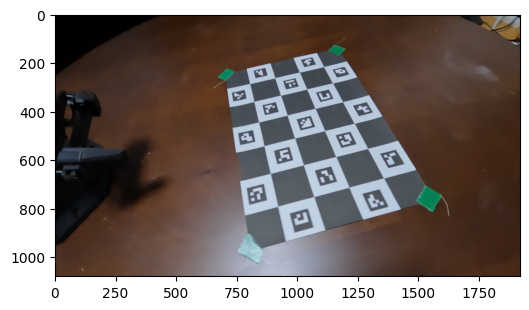

In [2]:
vid_path = "src/charuco.mp4"
save_dir = "./"

vid = imageio.mimread(vid_path, memtest=False)
print(len(vid), vid[0].shape)
plt.figure(figsize=(6,6)); plt.imshow(vid[75]); plt.show()

In [3]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_1000)
charuco = aruco.CharucoBoard_create(
    squaresX=5,
    squaresY=7,
    squareLength=0.04,  # no need to change
    markerLength=0.02,  # no need to change
    dictionary=aruco_dict)

cameraMatrix, distCoeffs = calibrate(vid[25:-25:5], aruco_dict, charuco)
with open(os.path.join(save_dir, 'camera_raw.pkl'), 'wb') as f:
    pickle.dump((cameraMatrix, distCoeffs), f)

vid_undist = undistort(vid[25:-25:5], cameraMatrix, distCoeffs)

cameraMatrix, distCoeffs = calibrate(vid_undist, aruco_dict, charuco)
with open(os.path.join(save_dir, 'camera_undist.pkl'), 'wb') as f:
    pickle.dump((cameraMatrix, distCoeffs), f)

Number of detected frames: 44
ret
 0.19077180131344515 
mtx
 [[921.17693718   0.         949.5952653 ]
 [  0.         922.21120489 549.32688644]
 [  0.           0.           1.        ]] 
dist
 [[ 0.02125802 -0.09120418  0.00306985 -0.00375586  0.14344269]]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 51.84it/s]


Number of detected frames: 44
ret
 0.22478218621658336 
mtx
 [[1.07866806e+03 0.00000000e+00 9.51601738e+02]
 [0.00000000e+00 1.08092892e+03 5.40184055e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
dist
 [[-1.89908535e-03  1.22776286e-02  1.35164476e-05  5.70933880e-05
  -1.78988620e-02]]


In [4]:
cube = np.float32([[0,0,0], [0,1,0], [1,1,0], [1,0,0],
                   [0,0,-1],[0,1,-1],[1,1,-1],[1,0,-1]])
cube =  (cube + np.array([[-0.5,-0.5,0]])) * 2. * charuco.getSquareLength()


def draw_cube(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)
    img = cv2.drawContours(img, [imgpts[[0,1,2,3]]], -1, (255,255,255), -1)
    img = cv2.drawContours(img, [imgpts[[0,1,5,4]]], -1, (255,255,255), -1)
    img = cv2.drawContours(img, [imgpts[[0,3,7,4]]], -1, (255,255,255), -1)
    img = cv2.drawContours(img, [imgpts[[1,2,6,5]]], -1, (255,255,255), -1)
    img = cv2.drawContours(img, [imgpts[[2,3,7,6]]], -1, (255,255,255), -1)
    img = cv2.drawContours(img, [imgpts[[4,5,6,7]]], -1, (255,255,255), -1)
    for i, j in zip(range(0, 4), range(4, 8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255,0,0), 3)
    img = cv2.drawContours(img, [imgpts[0:4]], -1, (255,0,0), 3)
    img = cv2.drawContours(img, [imgpts[4:8]], -1, (255,0,0), 3)
    return img


vid_paint = []

for t, img in enumerate(vid_undist):
    img = cv2.cvtColor(deepcopy(img), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    aruco_params = aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=aruco_params)

    corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
            image = gray,
            board = charuco,
            detectedCorners = corners,
            detectedIds = ids,
            rejectedCorners = rejectedImgPoints,
            cameraMatrix = cameraMatrix,
            distCoeffs = distCoeffs)

    if not (ids is not None and len(ids) > 1):
        continue

    response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
            markerCorners=corners,
            markerIds=ids,
            image=gray,
            board=charuco)

    if not (response is not None and response > 2):
        continue
            
    # Customized aruco.estimatePoseCharucoBoard
    objp = np.empty((0,3), np.float32)
    for idx in charuco_ids:
        objp = np.append(objp, charuco.chessboardCorners[idx] - np.array([[0.5,3.5,0]]) * 0.04, axis=0)
    valid, rvec, tvec = cv2.solvePnP(objp, charuco_corners, cameraMatrix, distCoeffs)

    if valid:
        imgpts, jac = cv2.projectPoints(cube, rvec, tvec, cameraMatrix, distCoeffs)
        img = draw_cube(img, imgpts)
        img = cv2.drawFrameAxes(img, cameraMatrix, distCoeffs, rvec, tvec, 0.3)

        img = aruco.drawDetectedMarkers(
            image=img,
            corners=corners)
        img = aruco.drawDetectedCornersCharuco(
            image=img,
            charucoCorners=charuco_corners,
            charucoIds=charuco_ids)

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    vid_paint.append(img)

imageio.mimwrite("src/temp.mp4", vid_paint, macro_block_size=8)

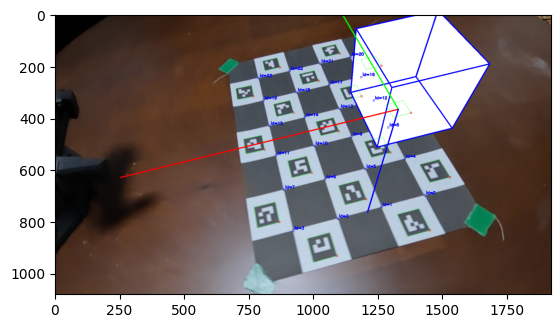

In [5]:
plt.imshow(vid_paint[10])

---

In [6]:
import cv2
import cv2.aruco as aruco
import imageio
import numpy as np
import matplotlib.pyplot as plt
import imageio
from copy import deepcopy
from tqdm import tqdm
import pickle

from utils import undistort


aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_1000)
charuco = aruco.CharucoBoard_create(
        squaresX=10,
        squaresY=7,
        squareLength=0.039,
        markerLength=0.0195,
        dictionary=aruco_dict)

In [7]:
with open('camera_raw.pkl', 'rb') as f:
    (mtx, dist) = pickle.load(f)

vid = imageio.mimread("../data/tmp/GX010054.MP4", memtest=False)
vid = undistort(vid, mtx, dist)

with open('camera_undist.pkl', 'rb') as f:
    (mtx, dist) = pickle.load(f)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 967/967 [00:18<00:00, 51.93it/s]


In [8]:
vid_sample, vid_paint, rvec_hist, tvec_hist = [], [], [], []

for t, img in enumerate(vid[25:-25:5]):
    bak = deepcopy(img)
    img = deepcopy(img[...,::-1])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    aruco_params = aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=aruco_params)

    corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
            image = gray,
            board = charuco,
            detectedCorners = corners,
            detectedIds = ids,
            rejectedCorners = rejectedImgPoints,
            cameraMatrix = mtx,
            distCoeffs = dist)

    img = aruco.drawDetectedMarkers(img, corners, borderColor=(0, 0, 255), ids=ids)

    if not (ids is not None and len(ids) > 1):
        print("skip (t={}, ids={})".format(t, ids))
        continue

    response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
            markerCorners=corners,
            markerIds=ids,
            image=gray,
            board=charuco)

    if response < 8:
        print("skip (t={}, response={})".format(t, response))
        continue

    # valid, rvec, tvec = aruco.estimatePoseCharucoBoard(
    #         charucoCorners=charuco_corners,
    #         charucoIds=charuco_ids,
    #         board=charuco, 
    #         cameraMatrix=mtx,
    #         distCoeffs=dist,
    #         rvec=None,
    #         tvec=None)
    
    objp = np.empty((0,3), np.float32)
    for idx in charuco_ids:
        objpi = np.dot(charuco.chessboardCorners[idx] - np.array([[5,7,0]]) * 0.04, np.array([[-1,0,0], [0,1,0], [0,0,-1]]))
        objp = np.append(objp, objpi, axis=0)

    valid, rvec, tvec = cv2.solvePnP(objp, charuco_corners, mtx, dist)

    if not valid:
        print("skip (t={}, valid={})".format(t, valid))
        continue

    img = cv2.drawFrameAxes(img, mtx, dist, rvec, tvec, 0.3)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    vid_sample.append(bak)
    vid_paint.append(img)
    rvec_hist.append(rvec)
    tvec_hist.append(tvec)

print(len(vid_sample))
imageio.mimwrite("src/temp.mp4", vid_paint, macro_block_size=8)

skip (t=0, response=2)
skip (t=1, response=5)
skip (t=2, response=3)
skip (t=3, response=3)
skip (t=4, response=2)
skip (t=5, response=5)
skip (t=6, response=7)
skip (t=7, response=6)
skip (t=9, response=3)
skip (t=11, response=6)
skip (t=15, response=2)
skip (t=20, response=7)
skip (t=41, response=1)
skip (t=44, response=1)
skip (t=51, response=1)
skip (t=52, response=2)
skip (t=53, response=7)
skip (t=54, response=6)
skip (t=55, ids=None)
skip (t=56, response=0)
skip (t=57, response=3)
skip (t=58, response=4)
skip (t=65, response=5)
skip (t=67, response=4)
skip (t=73, response=2)
skip (t=75, response=7)
skip (t=76, response=4)
skip (t=87, response=4)
skip (t=88, response=2)
skip (t=90, ids=[[22]])
skip (t=94, response=5)
skip (t=95, response=3)
skip (t=96, response=7)
skip (t=97, response=2)
skip (t=98, ids=None)
skip (t=99, response=7)
skip (t=100, response=7)
skip (t=101, response=6)
skip (t=105, response=6)
skip (t=109, response=2)
skip (t=111, response=0)
skip (t=114, response=7)

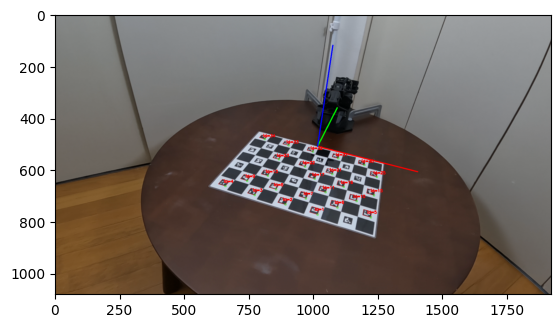

In [9]:
plt.imshow(vid_paint[10])

In [10]:
!rm -rf images

In [11]:
with open(os.path.join('poses.pkl'), 'wb') as f:
    pickle.dump((rvec_hist, tvec_hist), f)

# Save in Colmap format

In [72]:
import os
import PIL
import json

os.makedirs('images/', exist_ok=True)

out = {
    "fl_x": float(mtx[0,0]),
    "fl_y": float(mtx[1,1]),
    "cx": float(mtx[0,2]),
    "cy": float(mtx[1,2]),
    "w": 1920,
    "h": 1080,
    "camera_model": 'OPENCV',
    "k1": dist[0,0],
    "k2": dist[0,1],
    "p1": dist[0,2],
    "p2": dist[0,3],
}

poses = []
for t, (rvec, tvec) in enumerate(zip(rvec_hist, tvec_hist)):
    R, _ = cv2.Rodrigues(rvec)
    T = tvec

    c2w = np.eye(4)
    c2w[:3,3] = np.dot(R.T, - T).squeeze()
    # c2w[:3,:3] = R.T
    c2w[:3,:3] = np.dot(R.T, np.array([[1,0,0], [0,-1,0], [0,0,-1]]))
    poses.append(c2w)


frames = []

for t, (img, c2w) in enumerate(zip(vid_sample, poses)):
    name = 'images/frame_{:05}.png'.format(t)
    PIL.Image.fromarray(img).save(name, quality=95)  # heavy

    frame = {
        "file_path": name,
        "transform_matrix": c2w.tolist(),
    }
    frames.append(frame)

out["frames"] = frames

with open("transforms.json", "w", encoding="utf-8") as f:
    json.dump(out, f, indent=4)

In [52]:
len(vid_sample)

124

# Check rvec_hist and tvec_hist

In [53]:
c2w

array([[ 0.63916532,  0.61343318, -0.46386144,  0.57242062],
       [ 0.76473452, -0.57089254,  0.29876886, -0.29336908],
       [-0.0815403 , -0.54569354, -0.83400823,  0.82430968],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [127]:
with open(os.path.join('poses.pkl'), 'rb') as f:
    (rvec_hist, tvec_hist) = pickle.load(f)

In [128]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
from IPython.display import Image

def plot_all_frames(rvecs, tvecs, elev=90, azim=270):
    frames = []

    for t, (rvec, tvec) in enumerate(zip(rvecs, tvecs)):
        R, _ = cv2.Rodrigues(rvec)
        T = tvec  # T = tvec[0].T
        xyz = np.dot(R.T, - T).squeeze()
        rpy = np.deg2rad(cv2.RQDecomp3x3(R.T)[0])  # (not used)

        fig = plt.figure(figsize=(4,3))
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlim(-2, 2); ax.set_ylim(-2, 2); ax.set_zlim(-2, 2)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

        dx = np.dot(R.T, np.array([1,0,0]))
        dy = np.dot(R.T, np.array([0,1,0]))
        dz = np.dot(R.T, np.array([0,0,1]))

        # draw marker
        ax.scatter(0, 0, 0, color="k")
        ax.quiver(0, 0, 0, 1, 0, 0, length=1, color="r")
        ax.quiver(0, 0, 0, 0, 1, 0, length=1, color="g")
        ax.quiver(0, 0, 0, 0, 0, 1, length=1, color="b")
        ax.plot([-1,1,1,-1,-1], [-1,-1,1,1,-1], [0,0,0,0,0], color="k", linestyle=":")

        # draw camera
        colors = ['k', 'k', 'k'] if t < 5 else ['r', 'g', 'b']
        ax.quiver(*xyz, *dx, length=0.5, color=colors[0])
        ax.quiver(*xyz, *dy, length=0.5, color=colors[1])
        ax.quiver(*xyz, *dz, length=0.5, color=colors[2])

        # save for animation
        fig.canvas.draw()
        frames.append(np.array(fig.canvas.renderer.buffer_rgba()))
        plt.close()

    return frames

In [129]:
frames = plot_all_frames(rvec_hist[::5], tvec_hist[::5], elev=60, azim=-60)
imageio.mimwrite("src/sample3.gif", frames); Image(url='src/sample3.gif')

In [130]:
frames = plot_all_frames(rvec_hist[::5], tvec_hist[::5], elev=30, azim=-60)
imageio.mimwrite("src/sample4.gif", frames); Image(url='src/sample4.gif')

In [131]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
from IPython.display import Image

def plot_all_frames(rvecs, tvecs, elev=90, azim=270):
    frames = []

    for t, (rvec, tvec) in enumerate(zip(rvecs, tvecs)):
        R, _ = cv2.Rodrigues(rvec)
        T = tvec  # T = tvec[0].T
        xyz = T = np.dot(R.T, - T).squeeze()
        R = R.T
        # rpy = np.deg2rad(cv2.RQDecomp3x3(R.T)[0])  # (not used)

        fig = plt.figure(figsize=(4,3))
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlim(-2, 2); ax.set_ylim(-2, 2); ax.set_zlim(-2, 2)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

        R = np.dot(R, np.array([[1,0,0], [0,-1,0], [0,0,-1]]))
        dx = np.dot(R, np.array([1,0,0]))
        dy = np.dot(R, np.array([0,1,0]))
        dz = np.dot(R, np.array([0,0,1]))

        # draw marker
        ax.scatter(0, 0, 0, color="k")
        ax.quiver(0, 0, 0, 1, 0, 0, length=1, color="r")
        ax.quiver(0, 0, 0, 0, 1, 0, length=1, color="g")
        ax.quiver(0, 0, 0, 0, 0, 1, length=1, color="b")
        ax.plot([-1,1,1,-1,-1], [-1,-1,1,1,-1], [0,0,0,0,0], color="k", linestyle=":")

        # draw camera
        colors = ['k', 'k', 'k'] if t < 5 else ['r', 'g', 'b']
        ax.quiver(*xyz, *dx, length=0.5, color=colors[0])
        ax.quiver(*xyz, *dy, length=0.5, color=colors[1])
        ax.quiver(*xyz, *dz, length=0.5, color=colors[2])

        # save for animation
        fig.canvas.draw()
        frames.append(np.array(fig.canvas.renderer.buffer_rgba()))
        plt.close()

    return frames

In [132]:
frames = plot_all_frames(rvec_hist[::5], tvec_hist[::5], elev=60, azim=-60)
imageio.mimwrite("src/sample7.gif", frames); Image(url='src/sample7.gif')

In [133]:
frames = plot_all_frames(rvec_hist[::5], tvec_hist[::5], elev=30, azim=-60)
imageio.mimwrite("src/sample8.gif", frames); Image(url='src/sample8.gif')

# Colmap Pose Visualizer

In [73]:
# https://github.com/nerfstudio-project/nerfstudio/blob/b8f85fb603e426309697f7590db3e2c34b9a0d66/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#L71
import json
import numpy as np

filename = '/root/workspace/data/real/charuco/colmap/transforms.json'
# filename = 'transforms.json'
with open(filename, encoding="UTF-8") as file:
    meta = json.load(file)

poses = []

for frame in meta["frames"]:
    poses.append(np.array(frame["transform_matrix"]))

In [74]:
meta['frames'][0]

{'file_path': 'images/frame_00001.png',
 'transform_matrix': [[-0.8604647323768221,
   -0.4746746684048011,
   -0.18516048042299932,
   -2.538776281143756],
  [0.23038253868106495,
   -0.6866078970965754,
   0.6895603537874592,
   4.3296171155441],
  [-0.4544494803677867,
   0.5506846237361367,
   0.7001586355777083,
   -2.5859703540405903],
  [0.0, 0.0, 0.0, 1.0]]}

In [75]:
poses[0]

array([[-0.86046473, -0.47467467, -0.18516048, -2.53877628],
       [ 0.23038254, -0.6866079 ,  0.68956035,  4.32961712],
       [-0.45444948,  0.55068462,  0.70015864, -2.58597035],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [76]:
np.array(poses)[:,:3,3].max()

4.466315088005023

In [77]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from IPython.display import Image
import imageio

def plot_all_frames(poses, lim, elev=90, azim=270):
    frames = []

    for t, c2w in enumerate(poses):
        R = c2w[:3,:3]
        # R = np.dot(R, np.array([[1,0,0], [0,-1,0], [0,0,-1]]))
        # xyz = c2w[:3,3] + np.array([1, 1, 4])
        xyz = c2w[:3,3]

        fig = plt.figure(figsize=(4,3))
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim); ax.set_zlim(-lim, lim)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

        dx = np.dot(R, np.array([1,0,0]))  # R.T -> R
        dy = np.dot(R, np.array([0,1,0]))  # R.T -> R
        dz = np.dot(R, np.array([0,0,1]))  # R.T -> R

        # draw marker
        ax.scatter(0, 0, 0, color="k")
        ax.quiver(0, 0, 0, 1, 0, 0, length=1, color="r")
        ax.quiver(0, 0, 0, 0, 1, 0, length=1, color="g")
        ax.quiver(0, 0, 0, 0, 0, 1, length=1, color="b")
        ax.plot([-1,1,1,-1,-1], [-1,-1,1,1,-1], [0,0,0,0,0], color="k", linestyle=":")

        # draw camera
        colors = ['k', 'k', 'k'] if t < 5 else ['r', 'g', 'b']
        ax.quiver(*xyz, *dx, length=0.5, color=colors[0])
        ax.quiver(*xyz, *dy, length=0.5, color=colors[1])
        ax.quiver(*xyz, *dz, length=0.5, color=colors[2])

        # save for animation
        fig.canvas.draw()
        frames.append(np.array(fig.canvas.renderer.buffer_rgba()))
        plt.close()

    return frames

In [78]:
frames = plot_all_frames(poses[::5], lim=5, elev=60, azim=-60)
imageio.mimwrite("src/sample9.gif", frames); Image(url='src/sample9.gif')

In [79]:
frames = plot_all_frames(poses[::5], lim=5, elev=30, azim=-60)
imageio.mimwrite("src/sample10.gif", frames); Image(url='src/sample10.gif')